In [1]:
!pip install -q -U iterative-stratification optuna  catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 11.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import joblib

import math
import json

from pathlib import Path
import kagglehub
import shutil

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.multioutput import MultiOutputClassifier
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    make_scorer,
    jaccard_score,
    multilabel_confusion_matrix
)

import optuna
import shap

from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings('ignore')

In [3]:
random_state = 42
np.random.seed(random_state)

In [4]:
input_csv_file = 'processed_df.csv'
df = pd.read_csv(input_csv_file)

# Print the shape of the dataframe
print("-" * 40)
print(f"Shape of the dataframe df: {df.shape}")
print("-" * 40)

----------------------------------------
Shape of the dataframe df: (35260, 17)
----------------------------------------


In [5]:
# Converter colunas de falha para inteiro
failure_columns = [col for col in df.columns if col.startswith('f')]
for col in failure_columns:
    df[col] = df[col].astype(int)

In [6]:
df.drop(columns = ['numero_de_falhas', 'sensor_ok'], axis = 1, inplace=True)

In [7]:
df.head()

,id,id_produto,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina,fdf,fdc,fp,fte,fa
0,0,L56434,L,298.300000,309.1,90.0,1616.0,31.1,195.000000,0,0,0,0,0,0
1,1,L48741,L,298.200000,308.4,90.0,1388.0,53.8,137.000000,0,0,0,0,0,0
2,2,L48850,L,298.200000,307.8,90.0,1528.0,31.1,163.000000,0,0,0,0,0,0
3,3,M20947,M,300.900000,310.8,90.0,1599.0,33.0,7.000000,0,0,0,0,0,0
4,4,L53849,L,301.466667,310.5,90.0,1571.0,33.9,73.666667,0,0,0,0,0,0


In [8]:
# Identificar tipos de variáveis
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(exclude=[np.number]).columns.tolist()


In [9]:
numeric_features

['id',
 'temperatura_ar',
 'temperatura_processo',
 'umidade_relativa',
 'velocidade_rotacional',
 'torque',
 'desgaste_da_ferramenta',
 'falha_maquina',
 'fdf',
 'fdc',
 'fp',
 'fte',
 'fa']

In [10]:
categorical_features

['id_produto', 'tipo']

In [11]:
df.falha_maquina

,falha_maquina
0,0
1,0
2,0
3,0
4,0
...,...
35255,0
35256,0
35257,0
35258,0


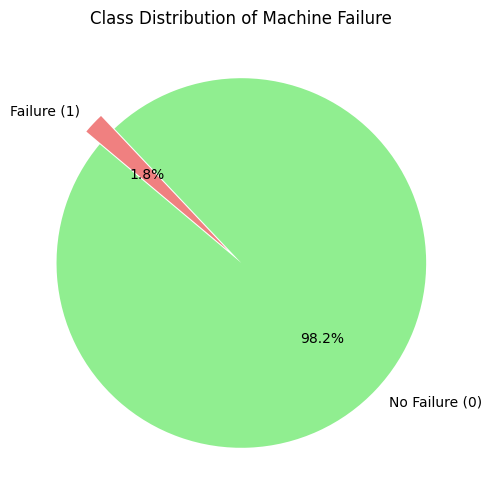

In [12]:
# Compute class distribution for Machine failure
class_distribution = df['falha_maquina'].value_counts(normalize=True) * 100

# Define labels and colors
labels = ['No Failure (0)', 'Failure (1)']
colors = ['lightgreen', 'lightcoral']

# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(class_distribution, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140, explode=[0, 0.1])
plt.title("Class Distribution of Machine Failure")
plt.show()

In [13]:
labels = [column for column in failure_columns if column != "falha_maquina"]
labels

['fdf', 'fdc', 'fp', 'fte', 'fa']


Class Distribution of Failure Types (Among Failures Only) (%):
fdf    10.153846
fdc    32.769231
fp     19.076923
fte    25.538462
fa      0.307692
dtype: float64


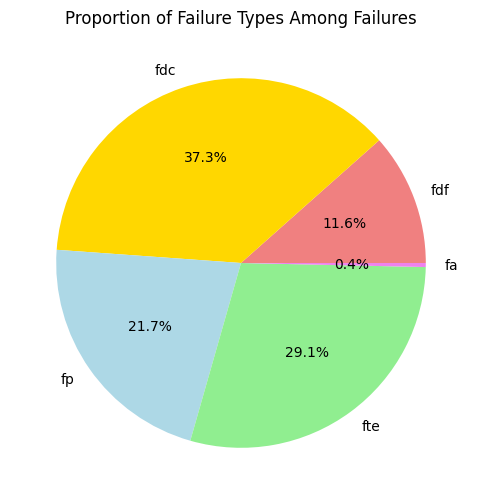

In [14]:
failure_cases = df[df['falha_maquina'] == 1]
failure_distribution = failure_cases[labels].sum()
failure_distribution_percentage = (failure_distribution / len(failure_cases)) * 100

# Display distribution
print("\nClass Distribution of Failure Types (Among Failures Only) (%):")
print(failure_distribution_percentage)

plt.figure(figsize=(6,6))
plt.pie(failure_distribution, labels=failure_distribution.index, autopct='%1.1f%%', colors=['lightcoral', 'gold', 'lightblue', 'lightgreen', 'violet'])
plt.title("Proportion of Failure Types Among Failures")
plt.show()

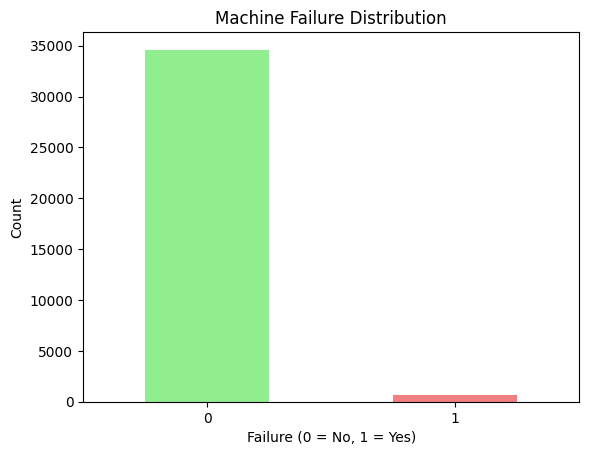

In [15]:
df['falha_maquina'].value_counts().plot(kind='bar', color=['lightgreen', 'lightcoral'])
plt.title("Machine Failure Distribution")
plt.xlabel("Failure (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

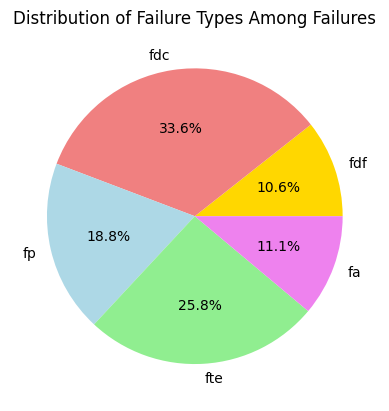

In [16]:
failure_counts = df[labels].sum()
plt.pie(failure_counts, labels=failure_counts.index, autopct='%1.1f%%', colors=['gold', 'lightcoral', 'lightblue', 'lightgreen', 'violet', 'orange'])
plt.title("Distribution of Failure Types Among Failures")
plt.show()

In [17]:
df.drop(columns=['falha_maquina'], axis = 1, inplace=True)

In [18]:
## From raw data to clean data and test train split

"""
This script defines the DataCleanerSplitter class, which handles:
1. Data Cleaning:
   - Renames columns for consistency.
   - Identifies and corrects inconsistencies in failure labels.
   - Ensures that each instance with a recorded machine failure has at least one failure type.
   - Saves both cleaned data with and without the 'machine_failure' column.

2. Train-Test Split:
   - Uses MultilabelStratifiedKFold to split the dataset into training and testing sets while maintaining label distributions.
   - Saves the split datasets to CSV files.
   - Prints dataset sizes and failure type distributions for validation.
""";

class DataCleanerSplitter:
    def __init__(self, df):
        """
        Initialize with the DataFrame and set necessary attributes.
        """
        self.df = df.copy()
        self.random_state = 42

        self.failure_types = labels

        # File names
        self.raw_file = "raw_data.csv"
        self.cleaned_file = "cleaned_data.csv"
        self.cleaned_file_with_failure = "cleaned_data_with_machine_failure.csv"
        self.train_file = "train_cleaned_data.csv"
        self.test_file = "test_cleaned_data.csv"

        # Save initial raw data
        self.df.to_csv(self.raw_file, index=False)

    def split_and_save_data(self):
        """
        Perform train-test split using MultilabelStratifiedKFold and save train and test datasets.
        """
        df = self.df

        # Initialize Stratified K-Fold
        mlkf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=self.random_state)

        # Separate features and target labels
        X = df.drop(columns=self.failure_types, errors='ignore')
        y = df[self.failure_types]

        # Perform stratified split
        for train_idx, test_idx in mlkf.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            break  # Use the first split

        # Save train and test datasets
        pd.concat([X_train, y_train], axis=1).to_csv(self.train_file, index=False)
        pd.concat([X_test, y_test], axis=1).to_csv(self.test_file, index=False)
        print(f"Train and test datasets saved.")

        # Print dataset sizes and distribution

        # Calculate total number of samples
        total_train = len(X_train)
        total_test = len(X_test)

        # Count instances with no failure (all failure type columns are 0)
        train_no_failure = (y_train.sum(axis=1) == 0).sum()
        test_no_failure = (y_test.sum(axis=1) == 0).sum()

        # Print train and test set sizes
        print(f"\nTrain set size: {total_train} ({total_train / len(df) * 100:.2f}%)")
        print(f"Test set size: {total_test} ({total_test / len(df) * 100:.2f}%)")

        # Print label distribution in train and test sets for validation
        print("\nLabel distribution in train set:")
        label_counts_train = y_train.sum().to_frame().rename(columns={0: "Count"})
        label_counts_train["Percentage"] = (label_counts_train["Count"] / total_train * 100).apply(lambda x: f"{x:.2f}%")
        print(label_counts_train.to_string())
        # Print number of rows with no failure
        print(f"Rows with no failure in train set: {train_no_failure} ({train_no_failure / total_train * 100:.2f}%)")

        print("\nLabel distribution in test set:")
        label_counts_test = y_test.sum().to_frame().rename(columns={0: "Count"})
        label_counts_test["Percentage"] = (label_counts_test["Count"] / total_test * 100).apply(lambda x: f"{x:.2f}%")
        print(label_counts_test.to_string())
        # Print number of rows with no failure
        print(f"Rows with no failure in test set: {test_no_failure} ({test_no_failure / total_test * 100:.2f}%)")

    def initiate_data_cleanersplitter(self):
        """
        Perform the entire data cleaning and train-test split process.
        """
        print(f"\nStarting train-test split process...")
        self.split_and_save_data()
        print(f"\nData cleaning and train-test split completed.")

In [19]:
# Create an instance of the DataCleanerSplitter class with the input DataFrame 'df'
data_cleaner_splitter = DataCleanerSplitter(df)

# Perform data cleaning and train-test splitting
data_cleaner_splitter.initiate_data_cleanersplitter()


Starting train-test split process...
Train and test datasets saved.

Train set size: 28208 (80.00%)
Test set size: 7052 (20.00%)

Label distribution in train set:
     Count Percentage
fdf     56      0.20%
fdc    177      0.63%
fp      99      0.35%
fte    136      0.48%
fa      59      0.21%
Rows with no failure in train set: 27694 (98.18%)

Label distribution in test set:
     Count Percentage
fdf     14      0.20%
fdc     44      0.62%
fp      25      0.35%
fte     34      0.48%
fa      14      0.20%
Rows with no failure in test set: 6926 (98.21%)

Data cleaning and train-test split completed.


In [20]:
'''
This code defines a preprocessing pipeline for machine learning data transformation.
It includes three custom transformer classes:
1. `DropColumns`: Drops specified columns from the dataset.
2. `OneHotEncoding`: Performs one-hot encoding on specified categorical columns.
3. `ScaleFeatures`: Scales specified numerical features using MinMaxScaler.

After defining the transformers, a `Pipeline` is created to execute the transformations in sequence:
- First, it drops unnecessary columns (`udi` and `product_id`).
- Then, it applies one-hot encoding to the categorical column (`type`).
- Finally, it scales the numerical features to a normalized range.

The resulting `preprocessor` pipeline can be applied to a dataset for consistent preprocessing.
''';

class DropColumns(BaseEstimator, TransformerMixin):
    """
    Transformer to drop specified columns.
    """
    def __init__(self, columns_to_drop):  # Initialize with the list of columns to drop
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):  # No fitting required, return self
        return self

    def transform(self, X):  # Drop the specified columns and store remaining columns
        try:
          self.remaining_columns = X.drop(columns=self.columns_to_drop, axis=1).columns.tolist()
          return X.drop(columns=self.columns_to_drop, axis=1)
        except:
          return X

class OneHotEncoding(BaseEstimator, TransformerMixin):
    """
    Transformer for one-hot encoding categorical columns.
    """
    def __init__(self, columns):
        self.columns = columns
        self.encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')  # Avoid dummy variable trap

    def fit(self, X, y=None):
        self.encoder.fit(X[self.columns])
        self.feature_names = self.encoder.get_feature_names_out(self.columns)
        return self

    def transform(self, X):
        X = X.copy()
        encoded_data = pd.DataFrame(self.encoder.transform(X[self.columns]),
                                    columns=self.feature_names,
                                    index=X.index)  # Preserve original index
        X = X.drop(columns=self.columns)  # No index reset to prevent misalignment
        X = pd.concat([X, encoded_data], axis=1)
        return X

class ScaleFeatures(BaseEstimator, TransformerMixin):
    """
    Scales specified numerical features using MinMaxScaler.
    """
    def __init__(self, columns_to_scale):
        self.columns = columns_to_scale
        self.scaler = MinMaxScaler()

    def fit(self, X, y=None):
        available_cols = [col for col in self.columns if col in X.columns]  # Avoid missing column errors
        self.scaler.fit(X[available_cols])
        return self

    def transform(self, X):
        X = X.copy()
        available_cols = [col for col in self.columns if col in X.columns]  # Check columns before scaling
        X[available_cols] = self.scaler.transform(X[available_cols])
        return X


# Define the columns for preprocessing

# List of columns to be dropped from the dataset
drop_columns = ['id', 'id_produto']

# List of categorical features to be one-hot encoded
categorical_features = ['tipo']

# List of numerical features to be scaled using MinMaxScaler
numeric_features = [
 'temperatura_ar',
 'temperatura_processo',
 'umidade_relativa',
 'velocidade_rotacional',
 'torque',
 'desgaste_da_ferramenta',
]

# Create a preprocessing pipeline that sequentially applies transformations
preprocessor = Pipeline([
    ('drop_columns', DropColumns(columns_to_drop=drop_columns)),  # Drop unnecessary columns
    ('label_encoding', OneHotEncoding(columns=categorical_features)),  # Apply one-hot encoding to categorical features
    ('scale_features', ScaleFeatures(columns_to_scale=numeric_features)),  # Scale numerical features
])

In [21]:
# Load cleaned data
train_cleaned_data = pd.read_csv('train_cleaned_data.csv')
test_cleaned_data = pd.read_csv('test_cleaned_data.csv')


# Split features (X) and labels (y)
X_train_cleaned = df.drop(columns=labels)
y_train = df[labels]

X_test_cleaned = test_cleaned_data.drop(columns=labels)
y_test = test_cleaned_data[labels]

# Fit and transform the training data
X_train_preprocessed = preprocessor.fit_transform(X_train_cleaned)


# Convert to DataFrame with correct column names
train_preprocessed = X_train_preprocessed.copy()
train_preprocessed[labels] = y_train.values  # Add target labels

# Transform the test data
X_test_preprocessed = preprocessor.transform(X_test_cleaned)
test_preprocessed = X_test_preprocessed.copy()
test_preprocessed[labels] = y_test.values  # Add target labels

# Save the preprocessor pipeline
joblib.dump(preprocessor, 'preprocessor.joblib')

# Save processed data
train_preprocessed.to_csv('train_preprocessed.csv', index=False)
test_preprocessed.to_csv('test_preprocessed.csv', index=False)

print("Preprocessed train and test datasets saved.")

Preprocessed train and test datasets saved.


In [22]:
train_df = pd.read_csv('train_preprocessed.csv')

## Encontrei no Medium uma maneira de lidar com dados desbalanceados em problemas MultiLabel
https://medium.com/thecyphy/handling-data-imbalance-in-multi-label-classification-mlsmote-531155416b87

In [23]:
class MLSMOTEProcessor:
    def __init__(self, train_data_df, failure_types, target_size=500, k=2, output_file='resampled_data.csv', save_dir='plots'):
        # Initialize the processor with training data, failure types, and other parameters
        self.train_data_df = train_data_df
        self.failure_types = failure_types
        self.target_size = target_size  # Target number of samples after resampling
        self.k = k  # Number of nearest neighbors for MLSMOTE
        self.output_file = output_file  # File to save resampled data
        self.save_dir = save_dir  # Directory to save plots
        self.ensure_directory()  # Ensure the plot directory exists

    def ensure_directory(self):
        """Ensure the directory for saving plots exists."""
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)  # Create the directory if it doesn't exist

    def print_label_distribution(self, y_train):
        """
        Prints the distribution of labels in the training set, including
        the total number of samples, the number of instances with no failure,
        and the percentage distribution of each label.
        """
        total_train = len(y_train)  # Total number of samples in the training set
        train_no_failure = (y_train.sum(axis=1) == 0).sum()  # Count instances with no failure

        print("\nLabel distribution:")
        label_counts = y_train.sum().to_frame().rename(columns={0: "Count"})  # Count occurrences of each label
        label_counts["Percentage"] = (label_counts["Count"] / total_train * 100).apply(lambda x: f"{x:.2f}%")  # Calculate percentage distribution
        print(label_counts.to_string())

        # Print count and percentage of rows with no failure
        print(f"Rows with no failure: {train_no_failure} ({train_no_failure / total_train * 100:.2f}%)")

    def create_synthetic_sample(self, X, nn_array, Y, num_samples_needed):
        """
        Generate synthetic samples using nearest neighbors and preserve label distribution.

        Parameters:
        - X: Feature matrix of the minority class
        - nn_array: k-nearest neighbor indices
        - Y: Label matrix for the minority class
        - num_samples_needed: Number of synthetic samples required

        Returns:
        - synthetic_samples: New feature samples
        - synthetic_labels: Corresponding labels
        """
        synthetic_samples, synthetic_labels = [], []  # Lists to store synthetic samples and their labels

        for _ in range(num_samples_needed):  # Generate the required number of synthetic samples
            idx = np.random.randint(0, len(X))  # Randomly choose a sample index
            nn = np.random.choice(nn_array[idx])  # Select a neighbor index
            gap = np.random.rand()  # Random gap for interpolation between samples
            synthetic_sample = X[idx] + gap * (X[nn] - X[idx])  # Create synthetic feature sample
            synthetic_label = np.logical_or(Y[idx], Y[nn]).astype(int)  # Create synthetic label by combining original labels
            synthetic_samples.append(synthetic_sample)
            synthetic_labels.append(synthetic_label)

        return np.array(synthetic_samples), np.array(synthetic_labels)  # Return the synthetic samples and labels

    def apply_mlsmote(self):
        """
        Apply MLSMOTE to balance multi-label datasets, ensuring each class reaches `target_size`.
        """
        # Extract features and labels from the training data
        X_train = self.train_data_df.drop(columns=self.failure_types).values
        y_train = self.train_data_df[self.failure_types].values

        synthetic_X, synthetic_Y = [], []  # Lists to hold synthetic samples and their labels

        # Loop over each label to apply MLSMOTE
        for label_idx in range(y_train.shape[1]):
            label_indices = np.where(y_train[:, label_idx] == 1)[0]  # Get indices of the current label
            if len(label_indices) < 2:  # Skip if not enough samples to apply MLSMOTE
                continue

            X_minority = X_train[label_indices]  # Minority class samples
            y_minority = y_train[label_indices]  # Corresponding labels

            # Fit k-nearest neighbors to the minority class samples
            knn = NearestNeighbors(n_neighbors=min(self.k, len(label_indices)), metric='euclidean')
            knn.fit(X_minority)
            nn_array = knn.kneighbors(X_minority, return_distance=False)[:, 1:]  # Get the nearest neighbors

            num_samples_needed = self.target_size - len(X_minority)  # Calculate the number of synthetic samples needed
            if num_samples_needed > 0:  # If more samples are needed, generate them
                X_new, Y_new = self.create_synthetic_sample(X_minority, nn_array, y_minority, num_samples_needed)
                synthetic_X.append(X_new)
                synthetic_Y.append(Y_new)

        # If synthetic samples were generated, combine them with the original dataset
        if synthetic_X:
            synthetic_X = np.vstack(synthetic_X)
            synthetic_Y = np.vstack(synthetic_Y)
            X_resampled = np.vstack((X_train, synthetic_X))  # Combine original and synthetic features
            y_resampled = np.vstack((y_train, synthetic_Y))  # Combine original and synthetic labels
        else:
            X_resampled, y_resampled = X_train, y_train  # If no synthetic samples, keep original data

        # Convert resampled features and labels into DataFrames
        X_resampled_df = pd.DataFrame(X_resampled, columns=self.train_data_df.drop(columns=self.failure_types).columns)
        y_resampled_df = pd.DataFrame(y_resampled, columns=self.failure_types)

        #- After one-hot encoding, the categorical variable 'type' is split into multiple binary columns.
        #- SMOTE or other resampling techniques may generate fractional values in these one-hot encoded columns.
        #- Since these columns should only contain 0s and 1s (binary values), we round them to the nearest integer.
        #- We check if each column exists before rounding to avoid KeyError, since one-hot encoding may drop one category depending on the encoding method.

        # List of possible one-hot encoded category columns
        onehot_columns = ['type_L', 'type_M', 'type_H']

        # Iterate through the list and apply thresholding only if the column exists
        for col in onehot_columns:
            if col in X_resampled_df.columns:
                X_resampled_df[col] = (X_resampled_df[col] >= 0.5).astype(int)

        # Combine feature and label DataFrames
        resampled_df = pd.concat([X_resampled_df, y_resampled_df], axis=1)

        # Print the distribution of labels after resampling
        self.print_label_distribution(y_resampled_df)

        # Save the resampled dataset to a CSV file
        resampled_df.to_csv(self.output_file, index=False)
        print(f"Resampled dataset saved as: {self.output_file}")

        # Plot the PCA, histograms, and KDE plots for the resampled data
        self.plot_pca(X_train, synthetic_X, y_train, synthetic_Y)
        self.plot_feature_histograms(X_train, synthetic_X)
        self.plot_feature_kde(X_train, synthetic_X)

    def plot_pca(self, X_original, X_synthetic, y_original, y_synthetic):
        if len(X_synthetic) == 0:
            return  # Exit if no synthetic data is available

        # Extract feature names and number of labels
        feature_names = self.train_data_df[self.failure_types].columns
        num_features = y_original.shape[1]

        # Perform PCA to reduce to 2 components for visualization
        pca = PCA(n_components=2)
        X_all = np.vstack((X_original, X_synthetic))
        X_pca = pca.fit_transform(X_all)  # Apply PCA to the combined dataset

        # Split the PCA result back into original and synthetic datasets
        X_pca_original = X_pca[:len(X_original)]
        X_pca_synthetic = X_pca[len(X_original):]

        # Create a figure with a specific size for the subplots
        plt.figure(figsize=(20, num_features * 2))

        # Loop over each label and create a scatter plot for the PCA components
        for label_idx in range(num_features):
            original_points = X_pca_original[y_original[:, label_idx] == 1]
            synthetic_points = X_pca_synthetic[y_synthetic[:, label_idx] == 1]

            # Display the PCA plot for each label in a subplot (3 per row)
            plt.subplot((num_features // 3) + 1, 3, label_idx + 1)
            plt.scatter(original_points[:, 0], original_points[:, 1], label="Original", alpha=0.5, color='blue')
            plt.scatter(synthetic_points[:, 0], synthetic_points[:, 1], label="Synthetic", alpha=0.5, color='red')
            plt.title(f'PCA Visualization for Label {feature_names[label_idx]}')
            plt.xlabel('PCA Component 1')
            plt.ylabel('PCA Component 2')
            plt.legend()
            plt.grid()

        # Adjust layout and save the PCA plot
        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, 'feature_pca.png'))
        plt.show()
        plt.close()  # Close figure to free memory

    def plot_feature_histograms(self, X_original, X_synthetic, bins=30):
        feature_names = self.train_data_df.drop(columns=self.failure_types).columns
        num_features = X_original.shape[1]

        # Create a figure for plotting histograms with enough space for all features
        plt.figure(figsize=(20, num_features * 2))

        # Loop over each feature and create histograms for both original and synthetic data
        for i in range(num_features):
            plt.subplot((num_features // 3) + 1, 3, i + 1)  # Adjust subplot for 3 plots per row
            plt.hist(X_original[:, i], bins=bins, alpha=0.7, label='Original', color='blue', density=True)
            plt.hist(X_synthetic[:, i], bins=bins, alpha=0.5, label='Synthetic', color='red', density=True)
            plt.title(feature_names[i])
            plt.xlabel("Value")
            plt.ylabel("Density")
            plt.legend()

        # Adjust layout and save the histograms plot
        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, 'feature_histograms.png'))
        plt.show()
        plt.close()  # Close figure to free memory

    def plot_feature_kde(self, X_original, X_synthetic):
        feature_names = self.train_data_df.drop(columns=self.failure_types).columns
        num_features = X_original.shape[1]

        # Create a figure for plotting KDE plots with enough space for all features
        plt.figure(figsize=(20, num_features * 2))

        # Loop over each feature and create KDE plots for both original and synthetic data
        for i in range(num_features):
            plt.subplot((num_features // 3) + 1, 3, i + 1)  # Adjust subplot for 3 plots per row
            sns.kdeplot(X_original[:, i], label="Original", color='blue', fill=True, alpha=0.5)
            sns.kdeplot(X_synthetic[:, i], label="Synthetic", color='red', fill=True, alpha=0.5)
            plt.title(feature_names[i])
            plt.xlabel("Value")
            plt.ylabel("Density")
            plt.legend()

        # Adjust layout and save the KDE plot
        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, 'feature_kde.png'))
        plt.show()
        plt.close()


Label distribution:
     Count Percentage
fdf    521      1.40%
fdc    519      1.40%
fp     542      1.46%
fte    558      1.50%
fa     517      1.39%
Rows with no failure: 34620 (93.31%)
Resampled dataset saved as: resampled_data.csv


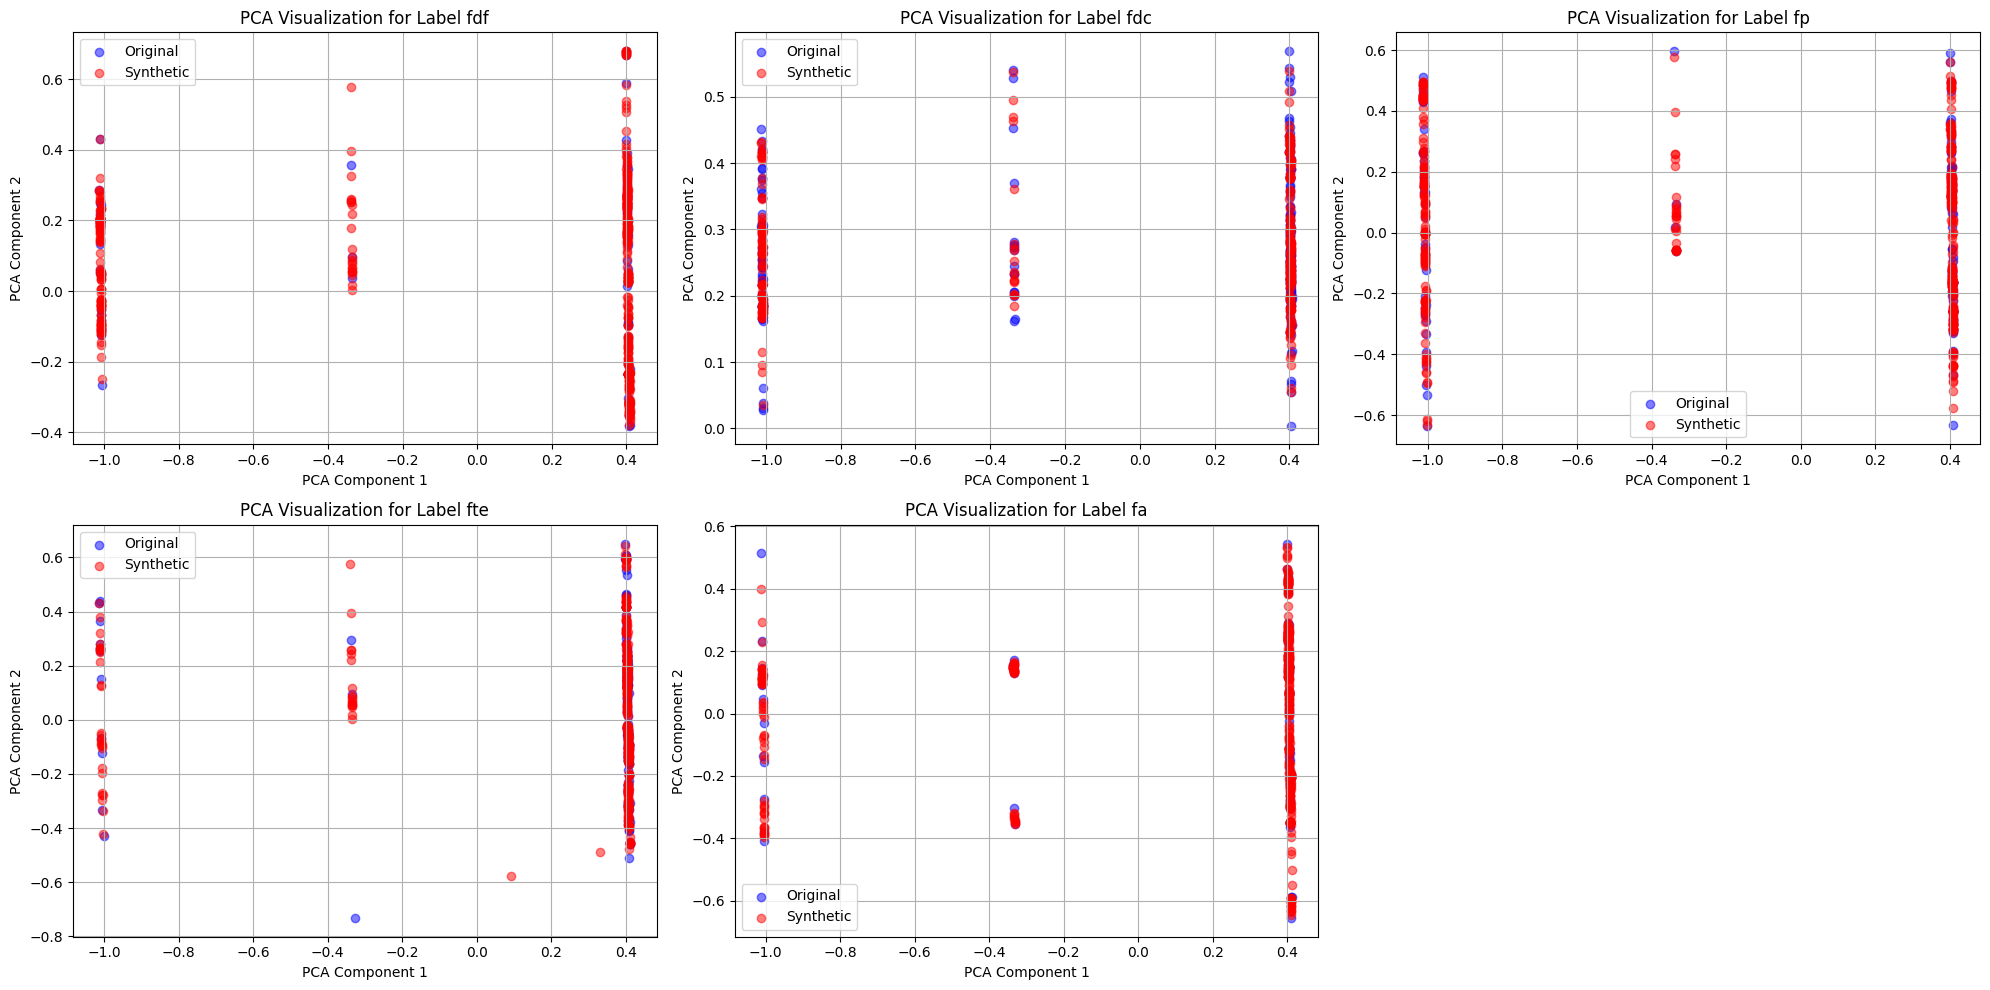

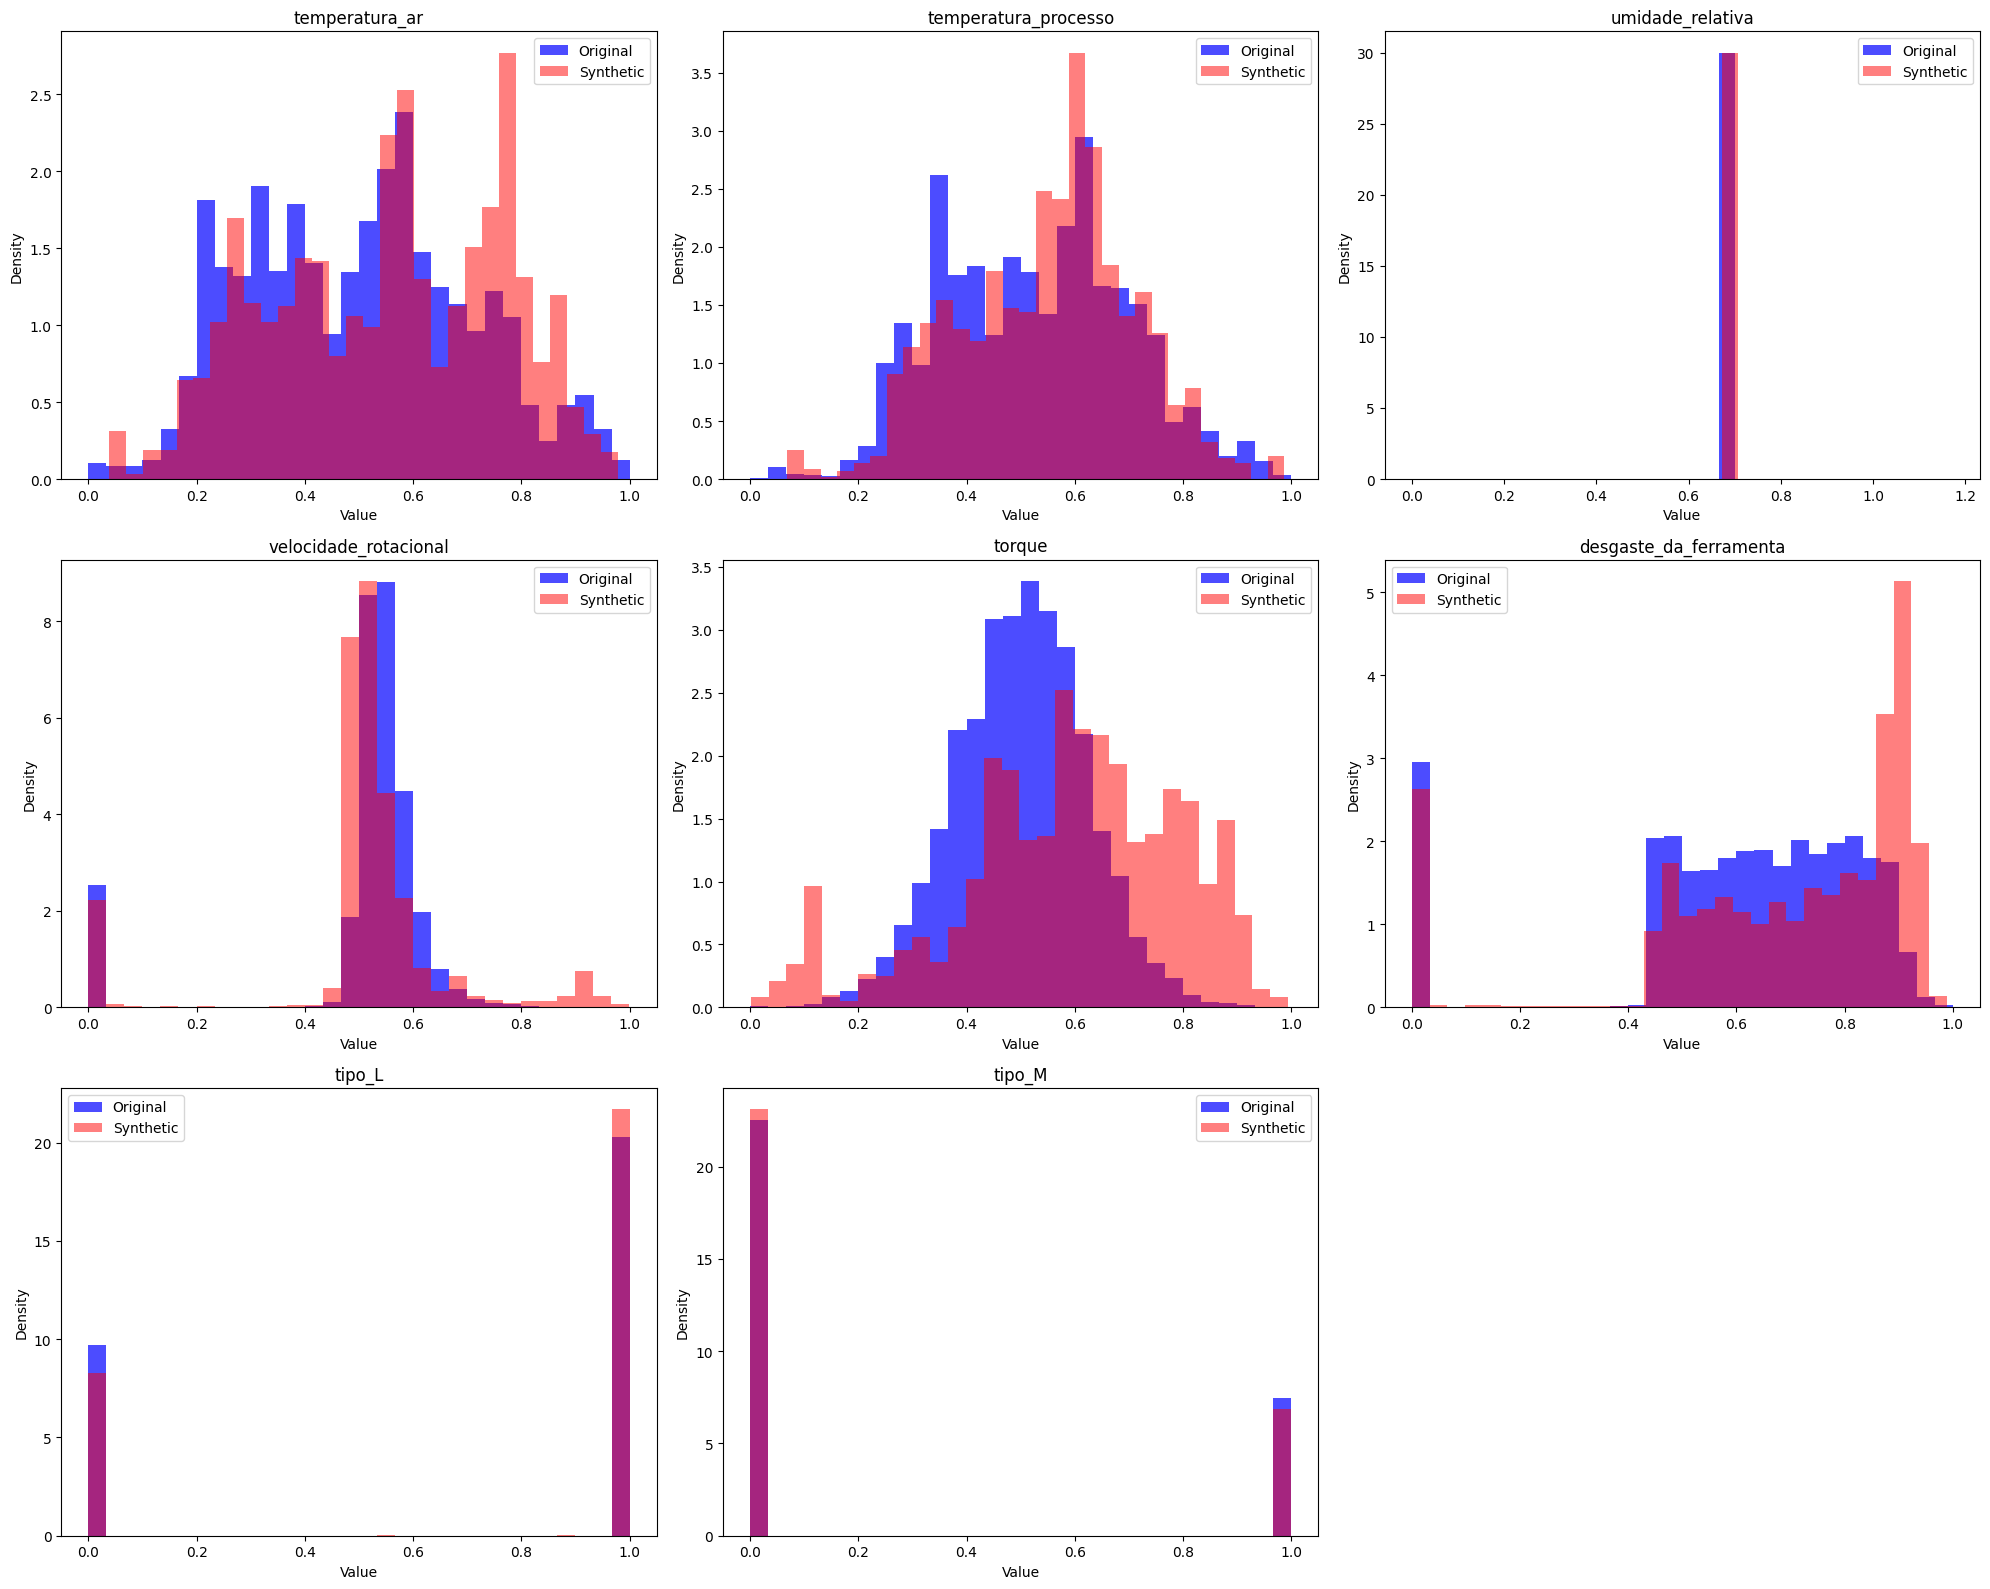

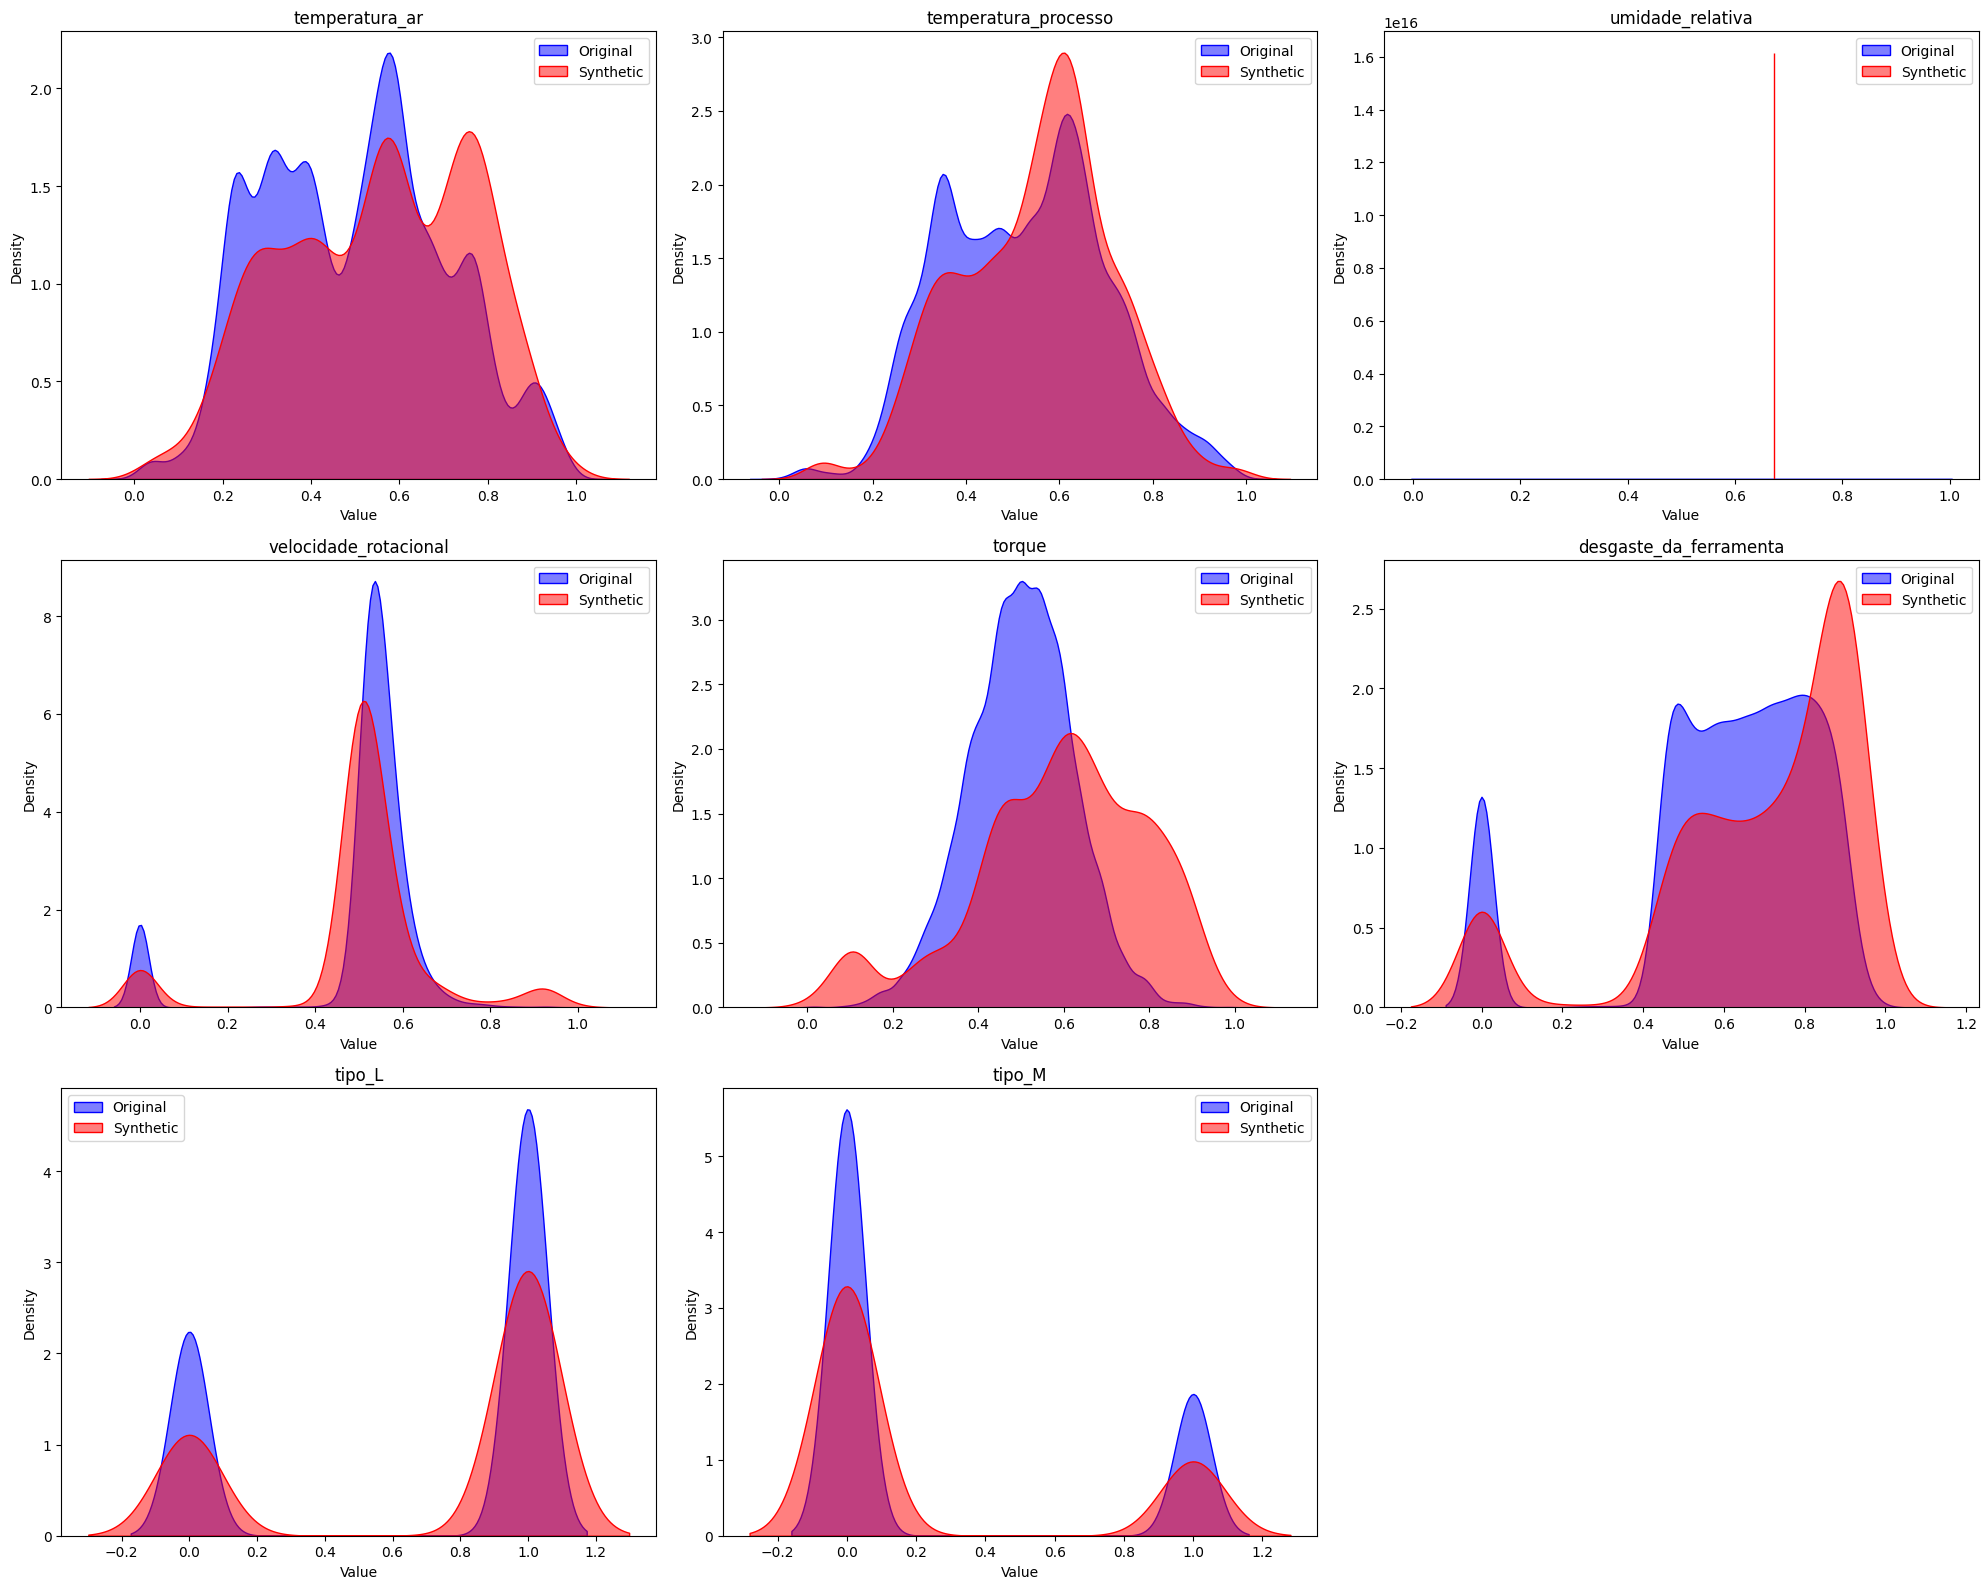

In [24]:
# Initialize the MLSMOTEProcessor object with the training data and failure types
mlsmote_processor = MLSMOTEProcessor(train_data_df=train_df, failure_types=labels)

# Apply MLSMOTE to balance the dataset by generating synthetic samples for the minority classes
mlsmote_processor.apply_mlsmote()

In [25]:
# Defining the models wrapped in MultiOutputClassifier for multi-label classification
base_models_classification_multilabel = {
    "logistic_regression": MultiOutputClassifier(LogisticRegression(random_state=random_state)),
    "decision_tree": MultiOutputClassifier(DecisionTreeClassifier(random_state=random_state)),
    "random_forest": MultiOutputClassifier(RandomForestClassifier(random_state=random_state)),
    "gradient_boosting": MultiOutputClassifier(GradientBoostingClassifier(random_state=random_state)),
    "adaboost": MultiOutputClassifier(AdaBoostClassifier(random_state=random_state)),
    "xgboost": MultiOutputClassifier(XGBClassifier(random_state=random_state, use_label_encoder=False, eval_metric="logloss")),
    "catboost": MultiOutputClassifier(CatBoostClassifier(random_state=random_state, verbose=0)),
}

In [26]:
def cross_validate_and_plot(X, y, base_models, metric="f1", cv=None, json_path="cv_results.json", plot_path="cv_results.jpg"):
    """
    Perform cross-validation for multi-label classification models, save results to JSON, and save a box plot as a JPG file.

    Parameters:
    - X: Feature matrix.
    - y: Multi-label target matrix.
    - base_models: Dictionary of models wrapped in MultiOutputClassifier.
    - metric: Evaluation metric ("f1" or "jaccard").
    - cv: Cross-validation strategy. If None, uses MultilabelStratifiedKFold.
    - json_path: Path to save cross-validation results as a JSON file.
    - plot_path: Path to save the box plot as a JPG file.

    Returns:
    - None
    """
    if cv is None:
        cv = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    scoring_metrics = {
        "f1": make_scorer(f1_score, average="micro"),
        "jaccard": make_scorer(jaccard_score, average="micro")
    }

    if metric not in scoring_metrics:
        raise ValueError(f"Invalid metric: {metric}. Choose from {list(scoring_metrics.keys())}")

    scorer = scoring_metrics[metric]
    results = []
    avg_scores = {}

    for model_name, model in base_models.items():
        scores = cross_val_score(model, X, y, cv=cv, scoring=scorer)
        avg_score = scores.mean()
        avg_scores[model_name] = avg_score  # Store the average score

        for score in scores:
            results.append({"Model": model_name, f"{metric.capitalize()} Score": score})

        print(f"{model_name}: Average {metric.capitalize()} Score = {avg_score:.4f}")

    # Convert results to DataFrame
    df_results = pd.DataFrame(results)

    # Save individual scores and average scores to JSON
    results_dict = {"models": {}}

    for model_name, scores in avg_scores.items():
        model_scores = [round(score, 4) for score in df_results[df_results["Model"] == model_name][f"{metric.capitalize()} Score"]]
        results_dict["models"][model_name] = {
            "individual_scores": model_scores,
            "average_score": round(avg_scores[model_name], 4)
        }

    with open("cv_results.json", "w") as f:
        json.dump(results_dict, f, indent=4)

    # Plot and save box plot
    plt.figure(figsize=(10, 6))
    metric_col = f"{metric.capitalize()} Score"
    sns.boxplot(x="Model", y=metric_col, data=df_results)
    plt.title(f"{metric.capitalize()} Score Box Plot")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(plot_path)  # Save plot instead of showing


In [27]:
# Load the resampled training dataset generated using MLSMOTE
resampled_train_df = pd.read_csv('resampled_data.csv')

# Separate features (X) and target labels (y) from the resampled training dataset
resampled_X_train = resampled_train_df.drop(columns=labels)  # Features
resampled_y_train = resampled_train_df[labels]  # Multi-label target variables

# Load the preprocessed test dataset
test_df = pd.read_csv('test_preprocessed.csv')

# Separate features (X) and target labels (y) from the test dataset
X_test = test_df.drop(columns=labels)  # Features
y_test = test_df[labels]  # Multi-label target variables

In [28]:
resampled_X_train

,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,tipo_L,tipo_M
0,0.326087,0.419753,0.672841,5.831966e-01,0.375000,0.872527,1.0,0.0
1,0.315217,0.333333,0.672841,5.083689e-01,0.686813,0.745055,1.0,0.0
2,0.315217,0.259259,0.672841,5.543157e-01,0.375000,0.802198,1.0,0.0
3,0.608696,0.629630,0.672841,5.776173e-01,0.401099,0.459341,0.0,1.0
4,0.670290,0.592593,0.672841,5.684280e-01,0.413462,0.605861,1.0,0.0
...,...,...,...,...,...,...,...,...
37097,0.056960,0.098606,0.672841,5.370331e-01,0.536397,0.668820,1.0,0.0
37098,0.184783,0.301758,0.672841,5.358309e-01,0.530526,0.727121,0.0,1.0
37099,0.506658,0.758241,0.672841,5.390518e-01,0.541547,0.585698,0.0,0.0
37100,0.797613,0.799516,0.672841,4.905178e-01,0.782078,0.818944,1.0,0.0


logistic_regression: Average F1 Score = 0.0271
decision_tree: Average F1 Score = 0.6769
random_forest: Average F1 Score = 0.7640
gradient_boosting: Average F1 Score = 0.5986
adaboost: Average F1 Score = 0.4149
xgboost: Average F1 Score = 0.7913
catboost: Average F1 Score = 0.7801


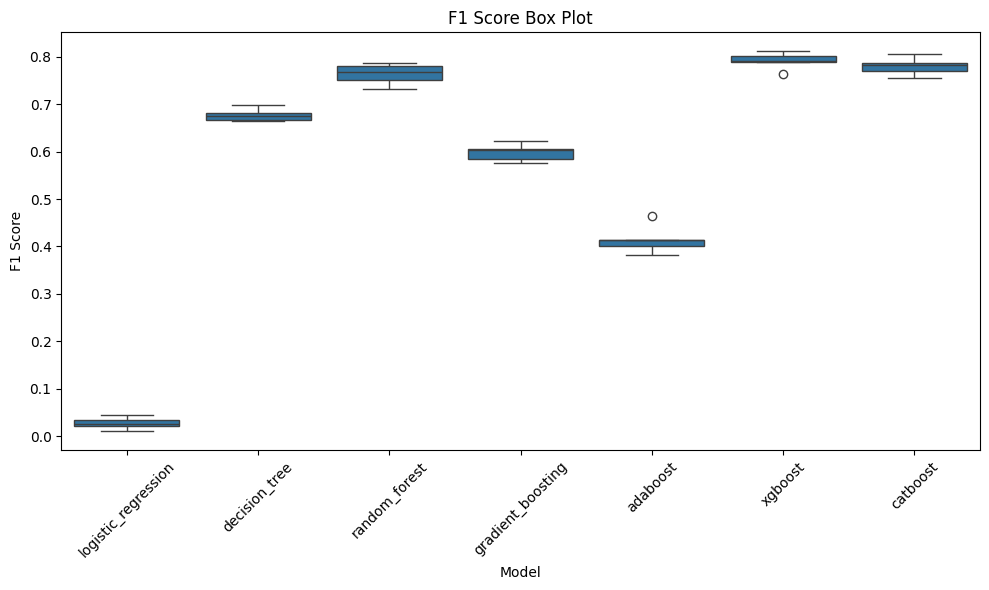

In [29]:
# Perform cross-validation on resampled dataset
cv_results = cross_validate_and_plot(
    resampled_X_train,
    resampled_y_train,
    base_models_classification_multilabel,
    metric="f1"
)

In [30]:
def plot_and_save_confusion_matrices(model_name, y_test, y_pred, folder_path="confusion_matrices"):
    """Plots and saves the confusion matrix for a single model."""
    os.makedirs(folder_path, exist_ok=True)

    cm = multilabel_confusion_matrix(y_test, y_pred)
    summed_cm = np.sum(cm, axis=0)  # Sum across labels to get an overview matrix

    plt.figure(figsize=(4, 3))
    sns.heatmap(summed_cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.tight_layout()

    save_path = os.path.join(folder_path, f"{model_name}_confusion_matrix.png")
    plt.savefig(save_path, dpi=300)

    plt.show()
    plt.close()  # Close figure to free memory

    print(f"Confusion matrix saved for {model_name} at: {save_path}")

In [31]:
def evaluate_multilabel_models(X_train, y_train, X_test, y_test, base_models, save_path="model_report.json", folder_path="confusion_matrices"):
    """
    Train base classifiers (default settings) and evaluate performance for multilabel classification.

    Args:
        X_train: Training features
        y_train: Training target (multilabel format)
        X_test: Testing features
        y_test: Testing target (multilabel format)
        base_models: Dictionary of base classifiers with their model names and objects
        save_path: Path to save the report as a JSON file (default: "model_report.json")

    Returns:
        report: Dictionary containing accuracy, precision, recall, F1-score, Jaccard similarity,
                and classification report for each model.
    """
    report = {}
    class_names = y_train.columns.tolist()

    for model_name, model in base_models.items():
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Compute multilabel metrics
        metrics = {
            'train_accuracy': accuracy_score(y_train, y_train_pred),
            'test_accuracy': accuracy_score(y_test, y_test_pred),
        }

        for avg in ['micro', 'macro', 'weighted']:
            metrics[f'train_precision_{avg}'] = precision_score(y_train, y_train_pred, average=avg, zero_division=0)
            metrics[f'test_precision_{avg}'] = precision_score(y_test, y_test_pred, average=avg, zero_division=0)

            metrics[f'train_recall_{avg}'] = recall_score(y_train, y_train_pred, average=avg, zero_division=0)
            metrics[f'test_recall_{avg}'] = recall_score(y_test, y_test_pred, average=avg, zero_division=0)

            metrics[f'train_f1_{avg}'] = f1_score(y_train, y_train_pred, average=avg, zero_division=0)
            metrics[f'test_f1_{avg}'] = f1_score(y_test, y_test_pred, average=avg, zero_division=0)

            metrics[f'train_jaccard_{avg}'] = jaccard_score(y_train, y_train_pred, average=avg, zero_division=0)
            metrics[f'test_jaccard_{avg}'] = jaccard_score(y_test, y_test_pred, average=avg, zero_division=0)

        # Store results
        report[model_name] = metrics
        report[model_name]['test_classification_report'] = classification_report(y_test, y_test_pred, target_names=class_names, zero_division=0)

        # Print micro F1-score, classification report and confusion matrix for each model
        print(f"\nModel: {model_name}")
        print(f"Train F1 Micro: {metrics['train_f1_micro']:.4f}")
        print(f"Test F1 Micro: {metrics['test_f1_micro']:.4f}")
        print("Classification Report:\n", metrics["test_classification_report"])
        # Compute and save confusion matrix without storing predictions
        plot_and_save_confusion_matrices(model_name, y_test, y_test_pred, folder_path)
        print("-"*60)

    # Save report as JSON
    with open(save_path, "w") as f:
        json.dump(report, f, indent=4)

    return report



Model: logistic_regression
Train F1 Micro: 0.0322
Test F1 Micro: 0.0567
Classification Report:
               precision    recall  f1-score   support

         fdf       0.00      0.00      0.00        14
         fdc       0.25      0.02      0.04        44
          fp       0.00      0.00      0.00        25
         fte       0.50      0.09      0.15        34
          fa       0.00      0.00      0.00        14

   micro avg       0.40      0.03      0.06       131
   macro avg       0.15      0.02      0.04       131
weighted avg       0.21      0.03      0.05       131
 samples avg       0.00      0.00      0.00       131



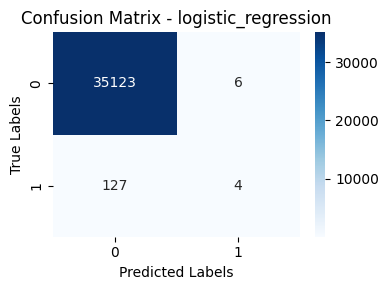

Confusion matrix saved for logistic_regression at: confusion_matrices/logistic_regression_confusion_matrix.png
------------------------------------------------------------

Model: decision_tree
Train F1 Micro: 0.9945
Test F1 Micro: 0.9845
Classification Report:
               precision    recall  f1-score   support

         fdf       1.00      0.93      0.96        14
         fdc       1.00      0.98      0.99        44
          fp       1.00      1.00      1.00        25
         fte       1.00      1.00      1.00        34
          fa       1.00      0.86      0.92        14

   micro avg       1.00      0.97      0.98       131
   macro avg       1.00      0.95      0.97       131
weighted avg       1.00      0.97      0.98       131
 samples avg       0.02      0.02      0.02       131



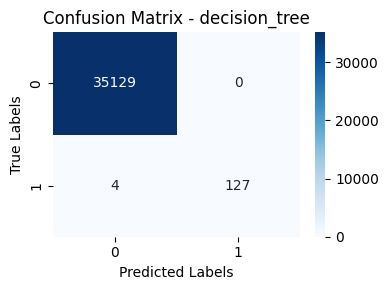

Confusion matrix saved for decision_tree at: confusion_matrices/decision_tree_confusion_matrix.png
------------------------------------------------------------

Model: random_forest
Train F1 Micro: 0.9945
Test F1 Micro: 0.9734
Classification Report:
               precision    recall  f1-score   support

         fdf       1.00      0.93      0.96        14
         fdc       0.96      1.00      0.98        44
          fp       1.00      1.00      1.00        25
         fte       0.94      1.00      0.97        34
          fa       1.00      0.86      0.92        14

   micro avg       0.97      0.98      0.97       131
   macro avg       0.98      0.96      0.97       131
weighted avg       0.97      0.98      0.97       131
 samples avg       0.02      0.02      0.02       131



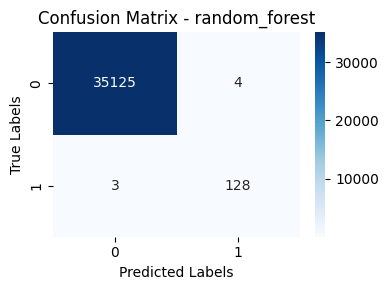

Confusion matrix saved for random_forest at: confusion_matrices/random_forest_confusion_matrix.png
------------------------------------------------------------

Model: gradient_boosting
Train F1 Micro: 0.7159
Test F1 Micro: 0.6142
Classification Report:
               precision    recall  f1-score   support

         fdf       0.50      0.14      0.22        14
         fdc       0.64      0.73      0.68        44
          fp       0.85      0.92      0.88        25
         fte       0.49      0.59      0.53        34
          fa       1.00      0.07      0.13        14

   micro avg       0.63      0.60      0.61       131
   macro avg       0.70      0.49      0.49       131
weighted avg       0.66      0.60      0.57       131
 samples avg       0.01      0.01      0.01       131



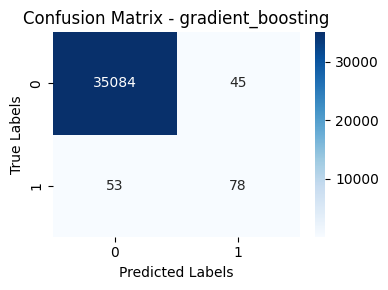

Confusion matrix saved for gradient_boosting at: confusion_matrices/gradient_boosting_confusion_matrix.png
------------------------------------------------------------

Model: adaboost
Train F1 Micro: 0.4293
Test F1 Micro: 0.4123
Classification Report:
               precision    recall  f1-score   support

         fdf       0.00      0.00      0.00        14
         fdc       0.62      0.45      0.53        44
          fp       0.51      0.72      0.60        25
         fte       0.39      0.26      0.32        34
          fa       0.00      0.00      0.00        14

   micro avg       0.48      0.36      0.41       131
   macro avg       0.31      0.29      0.29       131
weighted avg       0.41      0.36      0.37       131
 samples avg       0.01      0.01      0.01       131



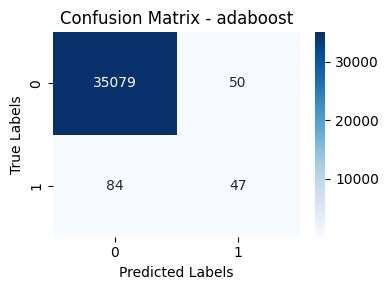

Confusion matrix saved for adaboost at: confusion_matrices/adaboost_confusion_matrix.png
------------------------------------------------------------

Model: xgboost
Train F1 Micro: 0.9839
Test F1 Micro: 0.9579
Classification Report:
               precision    recall  f1-score   support

         fdf       1.00      1.00      1.00        14
         fdc       0.96      1.00      0.98        44
          fp       1.00      1.00      1.00        25
         fte       0.94      0.97      0.96        34
          fa       0.90      0.64      0.75        14

   micro avg       0.96      0.95      0.96       131
   macro avg       0.96      0.92      0.94       131
weighted avg       0.96      0.95      0.95       131
 samples avg       0.02      0.02      0.02       131



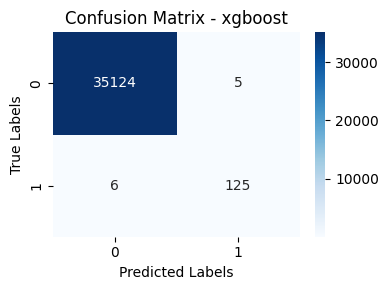

Confusion matrix saved for xgboost at: confusion_matrices/xgboost_confusion_matrix.png
------------------------------------------------------------

Model: catboost
Train F1 Micro: 0.9555
Test F1 Micro: 0.8907
Classification Report:
               precision    recall  f1-score   support

         fdf       1.00      0.64      0.78        14
         fdc       0.91      0.95      0.93        44
          fp       1.00      1.00      1.00        25
         fte       0.93      0.82      0.88        34
          fa       1.00      0.43      0.60        14

   micro avg       0.95      0.84      0.89       131
   macro avg       0.97      0.77      0.84       131
weighted avg       0.95      0.84      0.88       131
 samples avg       0.01      0.01      0.01       131



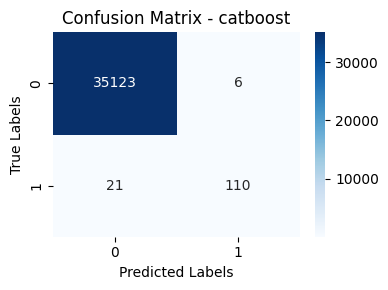

Confusion matrix saved for catboost at: confusion_matrices/catboost_confusion_matrix.png
------------------------------------------------------------


In [32]:
# Run evaluation
base_model_results = evaluate_multilabel_models(resampled_X_train, resampled_y_train, X_test, y_test, base_models_classification_multilabel)

In [34]:
def get_best_base_model(results, model_dict):
    best_base_model_name = None
    best_f1_macro = -1

    for model_name, metrics in results.items():
        f1_macro = metrics.get("test_f1_macro", -1)
        if f1_macro > best_f1_macro:
            best_f1_macro = f1_macro
            best_base_model_name = model_name

    best_base_model = model_dict.get(best_base_model_name, None)

    print(f"Best Base Model Name: {best_base_model_name} (Test F1-macro: {best_f1_macro:.4f})")
    print(f"Best Base Model: {best_base_model}")

    return {best_base_model_name: best_base_model} if best_base_model_name else {}

In [35]:
best_base_models = get_best_base_model(base_model_results, base_models_classification_multilabel)

Best Base Model Name: decision_tree (Test F1-macro: 0.9749)
Best Base Model: MultiOutputClassifier(estimator=DecisionTreeClassifier(random_state=42))


In [36]:
params_grid_optuna = {
    "logistic_regression": {
        "penalty": ["l1", "l2", "elasticnet", None],
        "C": (0.0001, 10.0),
        "solver": ["lbfgs", "saga", "liblinear"],
        "max_iter": (100, 500)
    },
    "decision_tree": {
        "criterion": ["gini", "entropy"],
        "max_depth": (5, 30),
        "min_samples_split": (2, 10),
        "min_samples_leaf": (1, 5),
        "max_features": ["sqrt", None]
    },

    "random_forest": {
        "n_estimators": (50, 200),
        "max_depth": (5, 30),
        "min_samples_split": (2, 10),
        "min_samples_leaf": (1, 5),
        "max_features": ["sqrt", "log2", None],
        "bootstrap": [True, False]
    },

    "gradient_boosting": {
        "n_estimators": (50, 200),
        "learning_rate": (0.01, 0.2),
        "max_depth": (3, 10),
        "min_samples_split": (2, 10),
        "min_samples_leaf": (1, 5),
        "subsample": (0.8, 1.0),
        "max_features": ["sqrt", "log2", None]
    },

    "adaboost": {
        "n_estimators": (50, 200),
        "learning_rate": (0.01, 1.0),
        "algorithm": ["SAMME", "SAMME.R"]
    },

    "xgboost": {
        "n_estimators": (50, 200),
        "learning_rate": (0.01, 0.3),
        "max_depth": (3, 10),
        "min_child_weight": (1, 5),
        "subsample": (0.8, 1.0),
        "colsample_bytree": (0.8, 1.0),
        "gamma": (0, 0.2)
    },

    "catboost": {
        "iterations": (100, 300),
        "learning_rate": (0.01, 0.3),
        "depth": (4, 10),
        "l2_leaf_reg": (1.0, 10.0),
        "border_count": (32, 128),
        "bootstrap_type": ["Bayesian", "Bernoulli", "MVS"]
    }
}


In [40]:
def objective(trial, model, X_train, y_train, X_test, y_test, param_grid):
    """Objective function for Optuna hyperparameter tuning."""

    # Suggest hyperparameters based on the param_grid
    params = {}
    for key, value in param_grid.items():
        if isinstance(value, list):  # Categorical
            params[key] = trial.suggest_categorical(key, value)
        elif isinstance(value, tuple):  # Numeric range
            if isinstance(value[0], int):
                params[key] = trial.suggest_int(key, value[0], value[1])
            else:
                params[key] = trial.suggest_float(key, value[0], value[1])

    # Set parameters and train model
    model.estimator.set_params(**params)
    model.fit(X_train, y_train)

    # Predict on the test set
    y_test_pred = model.predict(X_test)

    # Compute test F1-micro score
    test_f1_macro = f1_score(y_test, y_test_pred, average='macro', zero_division=0)

    return test_f1_macro  # Optuna maximizes this score

def hyperparameter_tuning_optuna(X_train, y_train, X_test, y_test, models, param_grids, n_trials=50):
    """
    Perform hyperparameter tuning using Optuna and evaluate models.

    Args:
        X_train: Training features
        y_train: Training labels
        X_test: Testing features
        y_test: Testing labels
        models: Dictionary of models
        param_grids: Dictionary of hyperparameter search spaces for each model
        n_trials: Number of trials for Optuna optimization
    """
    report = {}  # Store results
    best_tuned_model = None
    best_tuned_model_name = None
    best_test_f1_macro = -1  # Track the best model based on test F1-macro score
    class_names = y_test.columns.tolist()

    for model_name, model in models.items():
        print(f"Tuning {model_name}...")

        try:
            # Get hyperparameter space
            param_grid = param_grids[model_name]

            # Create an Optuna study
            study = optuna.create_study(direction="maximize")
            study.optimize(lambda trial: objective(trial, model, X_train, y_train, X_test, y_test, param_grid),
                           n_trials=n_trials, n_jobs=-1)

            # Get the best parameters
            best_params = study.best_params

            # Train model with best parameters
            model.estimator.set_params(**best_params)
            model.fit(X_train, y_train)

            # Predictions using the best model
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            # Compute evaluation metrics
            metrics = {
                'train_accuracy': accuracy_score(y_train, y_train_pred),
                'test_accuracy': accuracy_score(y_test, y_test_pred),
            }

            for avg in ['micro', 'macro', 'weighted']:
                metrics[f'train_precision_{avg}'] = precision_score(y_train, y_train_pred, average=avg, zero_division=0)
                metrics[f'test_precision_{avg}'] = precision_score(y_test, y_test_pred, average=avg, zero_division=0)

                metrics[f'train_recall_{avg}'] = recall_score(y_train, y_train_pred, average=avg, zero_division=0)
                metrics[f'test_recall_{avg}'] = recall_score(y_test, y_test_pred, average=avg, zero_division=0)

                metrics[f'train_f1_{avg}'] = f1_score(y_train, y_train_pred, average=avg, zero_division=0)
                metrics[f'test_f1_{avg}'] = f1_score(y_test, y_test_pred, average=avg, zero_division=0)

                metrics[f'train_jaccard_{avg}'] = jaccard_score(y_train, y_train_pred, average=avg, zero_division=0)
                metrics[f'test_jaccard_{avg}'] = jaccard_score(y_test, y_test_pred, average=avg, zero_division=0)

            # Store results
            report[model_name] = metrics
            report[model_name]['test_classification_report'] = classification_report(y_test, y_test_pred, target_names=class_names, zero_division=0)
            report[model_name]['best_params'] = best_params

            # Track the best model based on test F1-macro score
            if metrics['test_f1_macro'] > best_test_f1_macro:
                best_test_f1_macro = metrics['test_f1_macro']
                best_tuned_model = model
                best_tuned_model_name = model_name

        except Exception as e:
            print(f"Error in model {model_name}: {e}")

    if best_tuned_model_name:
        # Save report to JSON file
        with open("tuning_report.json", "w") as f:
            json.dump(report, f, indent=4)

        # Save the best tuned model name
        with open("best_tuned_model_name.txt", "w") as f:
            f.write(best_tuned_model_name)

        # Save the best tuned model
        joblib.dump(best_tuned_model, f"{best_tuned_model_name}_tuned_model.joblib")

        # Print best tuned model details
        print(f"\nBest Tuned Model: {best_tuned_model_name}")
        print(f"Test F1-macro: {report[best_tuned_model_name]['test_f1_macro']:.4f}")
        print("Classification Report:\n", report[best_tuned_model_name]['test_classification_report'])
        print("Best Hyperparameters:", report[best_tuned_model_name]['best_params'])
        y_test_pred = best_tuned_model.predict(X_test)

        # Save y_test_pred to CSV
        pd.DataFrame(y_test_pred, columns=[i for i in y_test.columns]) \
        .to_csv(f"{best_tuned_model_name}_y_test_pred.csv", index=False)

        # Plot and save confusion matrix
        plot_and_save_confusion_matrices(best_tuned_model_name, y_test, y_test_pred, folder_path="tuned_model_confusion_matrices")

[I 2025-09-01 22:14:51,290] A new study created in memory with name: no-name-73541bf5-e13f-41fa-889b-82565a1c2299


Tuning decision_tree...


[I 2025-09-01 22:14:51,881] Trial 0 finished with value: 0.5015174377801256 and parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 0 with value: 0.5015174377801256.
[I 2025-09-01 22:14:51,894] Trial 1 finished with value: 0.5015174377801256 and parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 0 with value: 0.5015174377801256.
[I 2025-09-01 22:14:52,155] Trial 3 finished with value: 0.4872080887149379 and parameters: {'criterion': 'gini', 'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5015174377801256.
[I 2025-09-01 22:14:52,264] Trial 2 finished with value: 0.5774644989713482 and parameters: {'criterion': 'entropy', 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 2 with value: 0.5774644989713


Best Tuned Model: decision_tree
Test F1-macro: 0.9749
Classification Report:
               precision    recall  f1-score   support

         fdf       1.00      0.93      0.96        14
         fdc       1.00      0.98      0.99        44
          fp       1.00      1.00      1.00        25
         fte       1.00      1.00      1.00        34
          fa       1.00      0.86      0.92        14

   micro avg       1.00      0.97      0.98       131
   macro avg       1.00      0.95      0.97       131
weighted avg       1.00      0.97      0.98       131
 samples avg       0.02      0.02      0.02       131

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


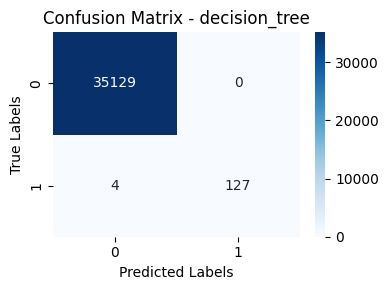

Confusion matrix saved for decision_tree at: tuned_model_confusion_matrices/decision_tree_confusion_matrix.png


In [41]:
hyperparameter_tuning_optuna(resampled_X_train, resampled_y_train, X_test, y_test, best_base_models, params_grid_optuna, n_trials=50)

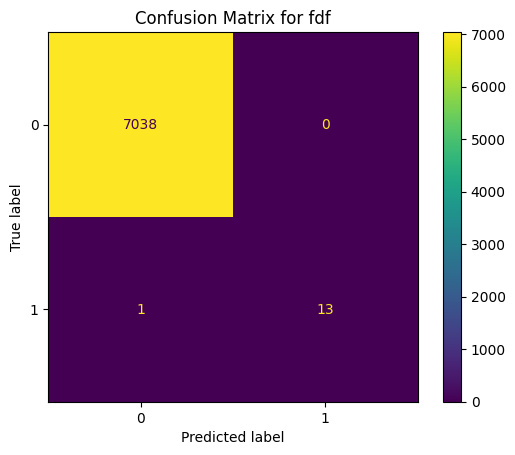

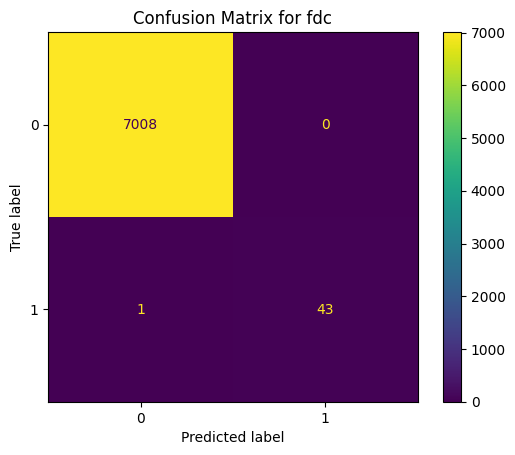

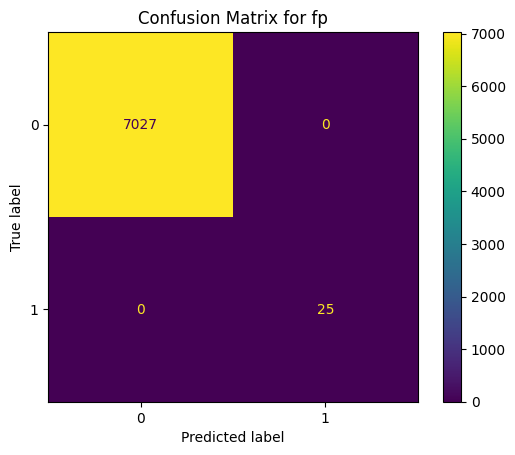

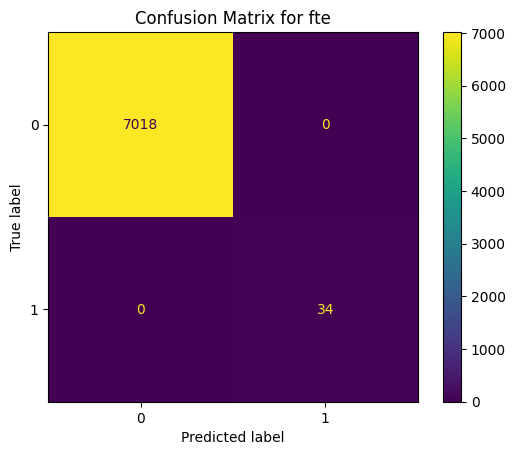

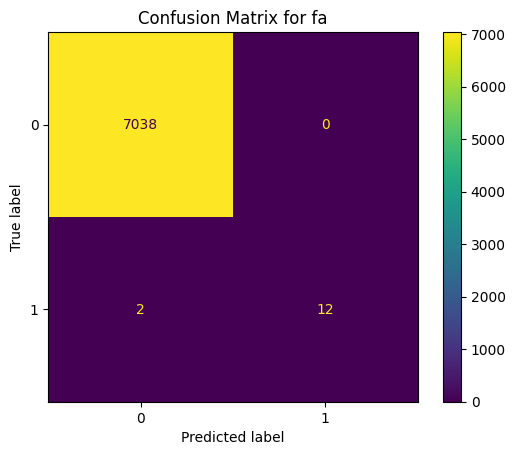

In [42]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the best model name
with open("best_tuned_model_name.txt", "r") as f:
    tuned_model_name = f.read().strip()

# Load the saved model
tuned_model = joblib.load(f"{tuned_model_name}_tuned_model.joblib")

# Load the test data
test_df = pd.read_csv('test_preprocessed.csv')

# Define failure types

# Separate features (X) and target labels (y) from the test dataset
X_test = test_df.drop(columns=labels)  # Features
y_test = test_df[labels]  # Multi-label target variables

# Make predictions using the best tuned model
y_test_pred = tuned_model.predict(X_test)

# Plot the confusion matrix for each failure type
for idx, failure_type in enumerate(labels):
    cm = confusion_matrix(y_test[failure_type], y_test_pred[:, idx])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix for {failure_type}')
    plt.show()

In [44]:
import pandas as pd
import joblib
# Load the test data
df_test = pd.read_csv("bootcamp_test.csv")


df_test_ids = df_test[['id']].copy()
# display(df_test)

# Drop unnecessary columns for prediction
try:
  df_test.drop(columns=['relative_humidity'], inplace=True)
except Exception as e:
  print(str(e))
  pass



display(df_test)

# Load the preprocessor object
preprocessor_loaded = joblib.load('preprocessor.joblib')

# Preprocess the user input data
df_test_processed = preprocessor_loaded.transform(df_test)

# Load the best model name
with open("best_tuned_model_name.txt", "r") as f:
    tuned_model_name = f.read().strip()

# Load the saved model
tuned_model = joblib.load(f"{tuned_model_name}_tuned_model.joblib")

# Make predictions using the optimized model
y_pred_test = tuned_model.predict(df_test_processed)

# Create a DataFrame with predictions and original IDs
predictions_df = pd.DataFrame(y_pred_test, columns=labels)
predictions_df = pd.concat([df_test_ids, predictions_df], axis=1)

# Display the predictions
display(predictions_df.head())

"['relative_humidity'] not found in axis"


,id,id_produto,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta
0,35260,L53432,L,300.8,310.3,90.0,1538,36.1,198
1,35261,M19544,M,303.6,311.8,90.0,1421,44.8,101
2,35262,M16591,M,298.3,307.9,90.0,1485,42.0,117
3,35263,L51922,L,303.3,311.3,90.0,1592,33.7,14
4,35264,L51701,L,302.4,310.4,90.0,1865,23.9,129
...,...,...,...,...,...,...,...,...,...
7168,42428,L55277,L,300.3,311.7,90.0,1501,38.2,24
7169,42429,L54825,L,300.4,311.4,90.0,1362,39.6,129
7170,42430,M23720,M,297.9,309.1,90.0,1741,28.6,30
7171,42431,L56161,L,297.0,307.7,90.0,1417,44.7,126


,id,fdf,fdc,fp,fte,fa
0,35260,0,0,0,0,0
1,35261,0,0,0,0,0
2,35262,0,0,0,0,0
3,35263,0,0,0,0,0
4,35264,0,0,0,0,0


In [45]:
rename = {
    "fdf": "FDF (Falha Desgaste Ferramenta)",
    "fdc": "FDC (Falha Dissipacao Calor)",
    "fp": "FP (Falha Potencia)",
    "fte": "FTE (Falha Tensao Excessiva)",
  "fa" : "FA (Falha Aleatoria)"
}

predictions_df = predictions_df.rename(columns=rename)
predictions_df.to_csv('predictions-ml.csv')

Preprocessor pipeline saved as preprocessor.pkl


In [46]:
# Create a final pipeline with the preprocessor and the best tuned model
final_pipeline = Pipeline([
    ('preprocessor', preprocessor_loaded),
    ('model', tuned_model)
])

import pickle
# Save the final pipeline
with open('pipeline_multilabel.pkl', 'wb') as f:
    pickle.dump(final_pipeline, f)


print("Final pipeline saved as pipeline_multilabel.pkl")

Final pipeline saved as pipeline_multilabel.pkl


In [47]:
tuned_model

MultiOutputClassifier(estimator=DecisionTreeClassifier(max_depth=28,
                                                       max_features='sqrt',
                                                       random_state=42))

In [ ]:
import joblib
import pandas as pd

# Load the saved pipeline
loaded_pipeline = joblib.load('pipeline_multilabel.pkl')

# Assuming you have new data in a pandas DataFrame called 'new_data_df'
# Replace this with your actual new data loading
# For demonstration, I'll use the existing test data
# new_data_df = pd.read_csv('your_new_data.csv')

# Make predictions using the loaded pipeline
predictions_on_new_data = loaded_pipeline.predict(df_test)

# Display the predictions
predictions_df = pd.DataFrame(predictions_on_new_data, columns=labels)

# Rename the columns
rename = {
    "fdf": "FDF (Falha Desgaste Ferramenta)",
    "fdc": "FDC (Falha Dissipacao Calor)",
    "fp": "FP (Falha Potencia)",
    "fte": "FTE (Falha Tensao Excessiva)",
    "fa" : "FA (Falha Aleatoria)"
}
predictions_df = predictions_df.rename(columns=rename)

# Add original IDs back
df_test_ids = df_test[['id']].copy()
predictions_df = pd.concat([df_test_ids, predictions_df], axis=1)

display(predictions_df.head())

,id,FDF (Falha Desgaste Ferramenta),FDC (Falha Dissipacao Calor),FP (Falha Potencia),FTE (Falha Tensao Excessiva),FA (Falha Aleatoria)
0,35260,0,0,0,0,0
1,35261,0,0,0,0,0
2,35262,0,0,0,0,0
3,35263,0,0,0,0,0
4,35264,0,0,0,0,0
